In [1]:
from input import *

locals().update(params_value_kragarm)

# Einführungsbeispiel

## Nachrechnung Kragarm

Um das Verhalten der FE-Programme mit Drehfedern einzuschätzen, werden Verformungen an einem fiktivem Beispiel bestimmt. Dargestellt ist der Kragarm in @fig-kragarm-feder. Die Verformung an der Stelle $w$ wird  händisch mittels Arbeitsgleichung und mit dem FE-Programm bestimmt. Es sollen nicht-lineare Federsteifigkeiten berücksichtigt werden können.

![Statisches System des Kragarms](../imgs/Kragarm_system_Feder.svg){#fig-kragarm-feder}



Die Parameter in der @tbl-parameters-kragarm dienen als Berechnungsgrundlagen. Beschrieben sind die Abmessungen und Materialeigenschaften, sowie die Beiden Laststufen $F_1$ und $F_2$ wie auch die  Federsteifigkeiten $k_1$ und $k_2$. Die Laststufen sind so gewählt, dass das nicht-lineare Verhalten der Drehfeder zu tragen kommt.

In [2]:
#| label: tbl-parameters-kragarm
#| tbl-cap: "Berechnungsparameter des Kragarms"

dict_to_table(params_kragarm)

|  Parameter  | ​  |
|---|---|
| $E = \frac{10000 \text{N}}{\text{mm}^{2}}$ | $F_{1} = - 10000 \text{N}$ |
| $F_{2} = - 21500 \text{N}$ | $b = 200 \text{mm}$ |
| $h = 400 \text{mm}$ | $k_{1} = \frac{100000 \text{N}}{\text{m}}$ |
| $k_{2} = \frac{10000 \text{N}}{\text{m}}$ | $l_{Kragarm} = 5 \text{m}$ |
| $z = 400 \text{mm}$ | ​  |


Der Querschnitt ist in @fig-qs-kragarm aufgezeigt.

![Fiktiver Querschnitt des Kragarms mit linear-elastischem Materialverhalten](../imgs/Kragarm_querschnitt.svg){#fig-qs-kragarm}

Die Entsprechende Federcharakteristik ist in @fig-springcharacteristic zu sehen.


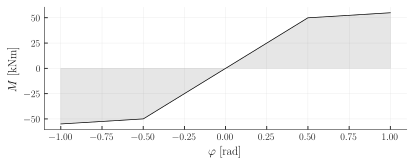

In [3]:
#| label: fig-springcharacteristic
#| fig-cap: "Charakteristik der Drehfeder"


def M_phi_spring(phi: np.array, k_phi1, k_phi2):
    phi_1, phi_2, phi_3, phi_4 = np.array_split(phi, 4)
    M_phi_1 = phi_3 * k_phi1
    M_phi_2 = M_phi_1[-1] + phi_3 * k_phi2
    M_phi_3 = np.flip(-M_phi_1)
    M_phi_4 = np.flip(-M_phi_2)

    M_phi = np.concatenate((M_phi_4, M_phi_3, M_phi_1, M_phi_2))
    return M_phi


# Arrays
Phi_spring_array = np.linspace(-1, 1, 1000)
M_phi_array = M_phi_spring(Phi_spring_array, k_1, k_2)


plt.plot(Phi_spring_array, M_phi_array / 10**3, color="black")
plt.fill_between(Phi_spring_array, M_phi_array / 10**3, color="black", alpha=0.1)

plt.xlabel("$\\varphi$ [rad]")
plt.ylabel("$M$ [kNm]")
plt.show()

### Biegeverformung

Zunächst werden die Biegeverformungen mittels der Differentialgleichung für reine Biegeträger ermittelt. Dabei wird die Drehfeder vernachlässigt. Das statische System, gezeigt in @fig-kragarm-sys führt zu den Zustandslinien der Schnittgrössen in der @fig-skkragarmreal.


![Statisches System des Kragarms](../imgs/Kragarm_System.svg){#fig-kragarm-sys}

In [4]:
# GEOMETRY System
x_array = np.linspace(0, to_float(l_Kragarm), 500)
q_array = np.zeros(len(x_array))
I = h**3 * b / 12


def V_x(c, q_x, x):
    q_integrated = integrate.cumulative_trapezoid(q_x, x, initial=0)
    return -q_integrated + c[0]


def M_x(c, q_x, x):
    V_x_calc = V_x(c, q_x, x)
    V_integrated = integrate.cumulative_trapezoid(V_x_calc, x, initial=0)
    return V_integrated + c[1]


def Phi_x(c, q_x, x, E, I):
    M_x_calc = M_x(c, q_x, x)
    M_integrated = integrate.cumulative_trapezoid(M_x_calc, x, initial=0)
    return 1 / (E * I) * M_integrated + c[2]


def w_x(c, q_x, x, E, I):
    Phi_x_calc = Phi_x(c, q_x, x, E, I)
    Phi_integrated = -integrate.cumulative_trapezoid(Phi_x_calc, x, initial=0)
    return Phi_integrated + c[3]


# Define the equations to solve


def calc_internal_forces(F: float):
    def initial_conditions(c):
        return [
            V_x(c, q_array, x_array)[0] + F,  # Shear force at the start is F
            M_x(c, q_array, x_array)[-1],  # Bending moment at the end is 0
            Phi_x(c, q_array, x_array, E, I)[0],  # Angle or rotation at the start is 0
            w_x(c, q_array, x_array, E, I)[0],
        ]  # Displacement at the start is 0

    # Solve for the integration constants
    integration_constants = fsolve(initial_conditions, [1, 1, 1, 1])

    V_x_array = V_x(integration_constants, q_array, x_array)
    M_x_array = M_x(integration_constants, q_array, x_array)
    Phi_x_array = Phi_x(integration_constants, q_array, x_array, E, I)
    w_x_array = w_x(integration_constants, q_array, x_array, E, I)

    return V_x_array, M_x_array, Phi_x_array, w_x_array


internal_forces_F1 = calc_internal_forces(F1)
internal_forces_F2 = calc_internal_forces(F2)

In [5]:
plot_counter_inner_forces = 1


def plot_inner_forces(
    V: np.array,
    M: np.array,
    Phi: np.array,
    w: np.array,
    x: np.array,
    kinematic=True,
    colors: list = ["green", "orange", "red", "blue"],
):
    global plot_counter_inner_forces

    fig, axs = plt.subplots(2, 2, figsize=(6, 4))

    # Plot V_x_array
    axs[0, 0].plot(x, V / 1000, color=colors[0], alpha=0.5)
    axs[0, 0].fill_between(x, V / 1000, color=colors[0], alpha=0.1)
    axs[0, 0].plot(x, x * 0, color="black")
    axs[0, 0].set_xlabel("$x$ [m]")
    axs[0, 0].set_ylabel("$V_x$ [kN]")

    # Plot M_x_array
    axs[0, 1].plot(x, M / 10**3, color=colors[1], alpha=0.5)
    axs[0, 1].fill_between(x, M / 10**3, color=colors[1], alpha=0.1)
    axs[0, 1].plot(x, x * 0, color="black")
    axs[0, 1].invert_yaxis()  # Invert the y-axis

    axs[0, 1].set_xlabel("$x$ [m]")
    axs[0, 1].set_ylabel("$M$ [kNm]")

    # Plot Phi_x_array
    axs[1, 0].plot(x, Phi, color=colors[2], alpha=0.5)
    axs[1, 0].fill_between(x, Phi, color=colors[2], alpha=0.1)
    axs[1, 0].plot(x, x * 0, color="black")
    axs[1, 0].set_xlabel("$x$ [m]")
    # axs[1, 0].set_ylim(0,1)
    axs[1, 0].set_ylabel("$\\varphi$ [-]")

    # Plot w_x_array
    axs[1, 1].plot(x, w * 1000, color=colors[3], alpha=0.5)
    axs[1, 1].fill_between(x, w * 1000, color=colors[3], alpha=0.1)
    axs[1, 1].plot(x, x * 0, color="black")
    axs[1, 1].invert_yaxis()  # Invert the y-axis
    axs[1, 1].set_xlabel("$x$ [m]")
    axs[1, 1].set_ylabel("$w$ [mm]")

    if kinematic == False:
        fig.delaxes(axs[1, 1])
        fig.delaxes(axs[1, 0])

    plt.tight_layout()
    plt.savefig(f"imgs/inner_forces_{plot_counter_inner_forces}.svg")
    plt.show()
    plot_counter_inner_forces += 1

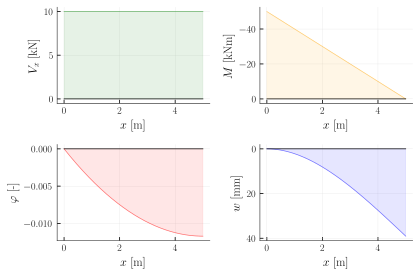

In [6]:
#| label: fig-skkragarmreal
#| fig-cap: "Schnittkräfte des Systems aus @fig-kragarm-sys für die Last $F_1$"

plot_inner_forces(*internal_forces_F1, x_array, kinematic=True)

In [7]:
w_max_hand = round(-F1 * l_Kragarm**3 / (3 * E * I), 5)
w_bending_F1 = round(internal_forces_F1[-1][-1], 5)

display_eq("w_1,Bending,F1", to_convert(w_bending_F1 * unit.meter, unit.mm))
assert w_max_hand == w_bending_F1, "Handcalculation shows differences"

w_1,Bending,F1 = 39.06⋅millimeter

@fig-skkragarmreal_high

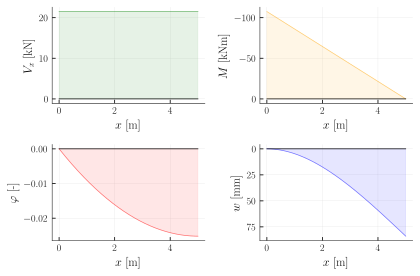

In [8]:
#| label: fig-skkragarmreal_high
#| fig-cap: "Schnittkräfte des Systems aus @fig-kragarm-sys für die Last $F2$"

plot_inner_forces(*internal_forces_F2, x_array)

In [9]:
w_bending_F2 = round(internal_forces_F2[-1][-1], 5)


display_eq("w_1,Bending,F_2", to_convert(w_bending_F2 * unit.meter, unit.mm))

w_1,Bending,F_2 = 83.98⋅millimeter

### Verformung der Drehfeder

Die Verformung aus der Drehfeder bedingt das Biegemoment des realen und des fiktiven Systems an der Stelle der Drehfeder, sowie die Federkonstante $k_\varphi$. Das virtuelle System is in @fig-kragarm-sys-virtuell gezeigt. 

![Statisches System des Kragarms im virtuellen Kräftezustand](../imgs/Kragarm_system_feder_virtuell.svg){#fig-kragarm-sys-virtuell}

Die entsprechenden Verläufe der Querkraft und des Biegemoments zeigt die @fig-sk-kragarm-virtuell.

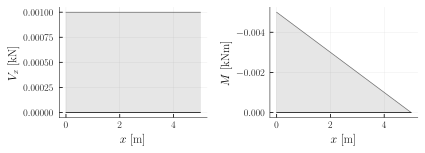

In [10]:
#| label: fig-sk-kragarm-virtuell
#| fig-cap: "Schnittkräfte des virtuellen Systems aus @fig-kragarm-sys-virtuell"

internal_forces_virtual = calc_internal_forces(-1.0)

plot_inner_forces(
    *internal_forces_virtual,
    x_array,
    kinematic=False,
    colors=["black", "black", "black", "black"]
)

Die @eq-spring_rotation berücksichtigt die Verformung durch die Drehfeder, basierend auf der Arbeitsgleichung.

$$
w_{Spring} = \bar{M} \frac{M}{k_\varphi} = \bar{M} \varphi
$${#eq-spring_rotation}

Angewendet auf das System der @fig-kragarm-feder folgen für die beiden Laststufen die Deformationen zu:

In [11]:
# Takes the corresponding phi for the middle M
phi_spring_F1 = np.interp(
    np.median(internal_forces_F1[1]), M_phi_array, Phi_spring_array
)
phi_spring_F2 = np.interp(
    np.median(internal_forces_F2[1]), M_phi_array, Phi_spring_array
)

In [12]:
w_spring_F1 = np.median(internal_forces_virtual[1]) * phi_spring_F1
w_spring_F2 = np.median(internal_forces_virtual[1]) * phi_spring_F2


display_eq(
    "w_1,spring,F1", unit.convert_to(np.round(w_spring_F1, 4) * unit.meter, unit.mm)
)
display_eq(
    "w_1,spring,F2", unit.convert_to(np.round(w_spring_F2, 4) * unit.meter, unit.mm)
)

w_1,spring,F1 = 625.0⋅millimeter

w_1,spring,F2 = 2201.3⋅millimeter

### Vergleich mit FE

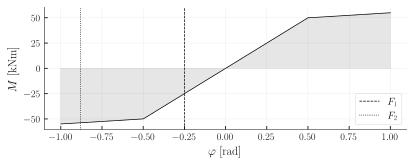

In [13]:
plt.plot(Phi_spring_array, M_phi_array / 10**3, color="black")
plt.fill_between(Phi_spring_array, M_phi_array / 10**3, color="black", alpha=0.1)

plt.axvline(x=phi_spring_F1, color="black", linestyle="--", label="$F_1$")
plt.axvline(x=phi_spring_F2, color="black", linestyle="dotted", label="$F_2$")


plt.xlabel("$\\varphi$ [rad]")
plt.ylabel("$M$ [kNm]")
plt.legend()
plt.savefig("imgs/spring_charact.svg")
plt.show()

In [14]:
w_tot_F1 = w_spring_F1 + w_bending_F1
display_eq("w_tot,F1", unit.convert_to(np.round(w_tot_F1, 5) * unit.meter, unit.mm))

w_tot,F1 = 664.06⋅millimeter

![Verformungen in $z$ Richtung mit FE für $F_2$](../imgs/kragarm_fe_F1.png)

In [15]:
w_tot_F2 = w_spring_F2 + w_bending_F2
display_eq("w_tot,F2", unit.convert_to(np.round(w_tot_F2, 5) * unit.meter, unit.mm))

w_tot,F2 = 2285.24⋅millimeter

![Verformungen in $z$ Richtung mit FE für $F_2$](../imgs/kragarm_fe_F2.png)

### Mit Wegfeder

#### Federgesetz

In [16]:
def F_u_spring(M: np.array, Phi: np.array, z: float):
    F = M / z
    u = Phi * z / 2

    return F, u


F_array, u_array = F_u_spring(M_phi_array, Phi_spring_array, z)

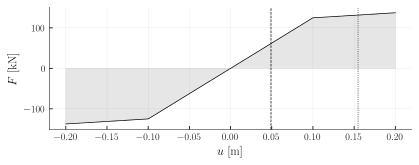

In [17]:
# The deformations for the corresponding F
index_F1 = np.argmin(np.abs(F_array - 61.25 * 1000))
u_F1 = u_array[index_F1]

index_F2 = np.argmin(np.abs(F_array - 131.69 * 1000))
u_F2 = u_array[index_F2]

plt.axvline(x=u_F1, color="black", linestyle="--", label="$F_1$")
plt.axvline(x=u_F2, color="black", linestyle="dotted", label="$F_2$")


plt.plot(u_array, F_array / 10**3, color="black")
plt.fill_between(u_array, F_array / 10**3, color="black", alpha=0.1)
plt.xlabel("$u$ [m]")
plt.ylabel("$F$ [kN]")
plt.savefig("imgs/F_u.svg")
plt.show()

In [18]:
diff_F = np.gradient(F_array)
diff_u = np.gradient(u_array)
F_of_u_derivative = diff_F / diff_u

k_1_weg = np.max(F_of_u_derivative[np.where(F_of_u_derivative >= 500000)])
k_2_weg = np.max(F_of_u_derivative[np.where(F_of_u_derivative <= 500000)])

alpha_weg = k_2_weg / k_1_weg

In [19]:
display_eq("k_1_x", unit.convert_to(np.round(k_1_weg, -2) * unit.N / unit.m, unit.kN))
display_eq("k_2_x", unit.convert_to(np.round(k_2_weg, -2) * unit.N / unit.m, unit.kN))

display_eq("alpha", np.round(alpha_weg, 3))

       1250.0⋅kilonewton
k₁ ₓ = ─────────────────
             meter      

       125.0⋅kilonewton
k₂ ₓ = ────────────────
            meter      

α = 0.1

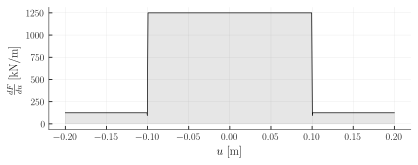

In [20]:
plt.plot(u_array, F_of_u_derivative / 10**3, color="black")
plt.fill_between(u_array, F_of_u_derivative / 10**3, color="black", alpha=0.1)
plt.xlabel("$u$ [m]")
plt.ylabel("$\\frac{dF}{du}$ [kN/m]")
plt.savefig("imgs/dF_u.svg")

plt.show()

In [21]:
np.max(u_array)

0.2

In [22]:
np.max(F_array)

137362.36236236233

In [23]:
index_F_0 = np.max(np.where(np.where(F_of_u_derivative <= 500 * 10**3)[0] <= 500))
F_0 = F_array[index_F_0]
u_0 = u_array[index_F_0]

display_eq("F_0", unit.convert_to(np.round(F_0, -2) * unit.N, unit.kN))
display_eq("u_0", unit.convert_to(np.round(u_0, 5) * unit.m, unit.mm))

F₀ = -124.9⋅kilonewton

u₀ = -100.3⋅millimeter

# Versuchsnachrechnung

## A3V2

In [24]:
#| label: tbl-parameters-kragarm2
#| tbl-cap: "Berechnungsparameter des Versuchs A3V2"

locals().update(params_value_a3v2)

dict_to_table(params_a3v2)

|  Parameter  | ​  |
|---|---|
| $F_{max} = - 320 \text{kN}$ | $l = 2.62 \text{m}$ |
| $l_{spring} = 2.0 \text{mm}$ | ​  |


### Drehfedercharakteristik

In [25]:
# Read the text file using numpy
M_array = np.loadtxt("docs/M_A3V2.txt")
chi_array = np.loadtxt("docs/chi_A3V2.txt")

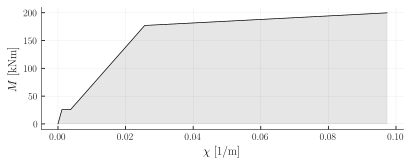

In [26]:
chi_interpolated = np.linspace(0, max(chi_array), 1000)
# Linear interpolation in M_array
M_interpolated = np.interp(chi_interpolated, chi_array, M_array)

# Plot the interpolated data
plt.plot(chi_interpolated, M_interpolated / 10**3, color="black")
plt.fill_between(chi_interpolated, M_interpolated / 10**3, color="black", alpha=0.1)
plt.xlabel("$\chi$ [1/m]")
plt.ylabel("$M$ [kNm]")
plt.show()

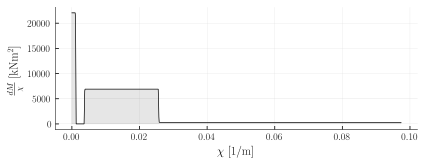

In [27]:
diff_M = np.gradient(M_interpolated)
diff_chi = np.gradient(chi_interpolated)
M_of_chi_derivative = diff_M / diff_chi


plt.plot(chi_interpolated, M_of_chi_derivative / 10**3, color="black")
plt.fill_between(
    chi_interpolated, M_of_chi_derivative / 10**3, color="black", alpha=0.1
)
plt.xlabel("$\chi$ [1/m]")
plt.ylabel("$\\frac{dM}{\chi}$ [kNm$^2$]")


plt.show()

In [28]:
l_element = 0.01 * unit.meter

### Wegfedercharakteristik


In [29]:
F_a3v2_array, u_a3v2_array = F_u_spring(M_array, chi_array * l_element, 0.4)

In [30]:
to_float(F_a3v2_array)

array([     0.        ,  64084.65197041,  64084.65197041, 442937.93690642,
       499619.28327056])

In [31]:
to_float(u_a3v2_array)

array([0.00000000e+00, 2.32374725e-06, 7.42601493e-06, 5.13268565e-05,
       1.94727767e-04])

In [32]:
to_float(u_a3v2_array).astype(float)

array([0.00000000e+00, 2.32374725e-06, 7.42601493e-06, 5.13268565e-05,
       1.94727767e-04])

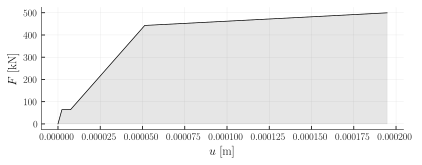

In [33]:
plt.plot(to_float(u_a3v2_array), to_float(F_a3v2_array) / 10**3, color="black")
plt.fill_between(
    to_float(u_a3v2_array).astype(float),
    to_float(F_a3v2_array).astype(float) / 10**3,
    color="black",
    alpha=0.1,
)
plt.xlabel("$u$ [m]")
plt.ylabel("$F$ [kN]")
plt.show()

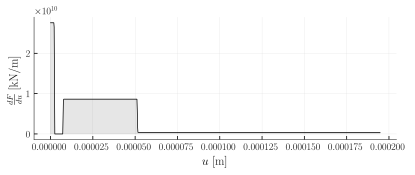

In [34]:
# Linear interpolation
u_interpolated_a3v2 = np.linspace(0, max(to_float(u_a3v2_array)), 1000).astype(float)

F_interpolated_a3v2 = np.interp(
    u_interpolated_a3v2, to_float(u_a3v2_array).astype(float), to_float(F_a3v2_array)
)

diff_F_a3v2 = np.gradient(F_interpolated_a3v2)
diff_u_a3v2 = np.gradient(u_interpolated_a3v2)
F_of_u_derivative_a3v2 = diff_F_a3v2 / diff_u_a3v2

plt.plot(to_float(u_interpolated_a3v2), to_float(F_of_u_derivative_a3v2), color="black")
plt.fill_between(
    to_float(u_interpolated_a3v2),
    to_float(F_of_u_derivative_a3v2),
    color="black",
    alpha=0.1,
)
plt.xlabel("$u$ [m]")
plt.ylabel("$\\frac{dF}{du}$ [kN/m]")


plt.show()

In [35]:
k_2_x_a3v2 = F_of_u_derivative_a3v2[-1]
k_1_x_a3v2 = F_of_u_derivative_a3v2[np.where(u_interpolated_a3v2 <= 2 * 10**-5)][-1]


alpha_a3v2 = k_2_x_a3v2 / k_1_x_a3v2

EA_weg_a3v2 = k_1_x_a3v2 * to_float(l_element)

In [36]:
display_eq(
    "k_1_x", unit.convert_to(np.round(k_2_x_a3v2, -2) * unit.N / unit.meter, unit.kN)
)
display_eq(
    "k_2_x", unit.convert_to(np.round(k_1_x_a3v2, -2) * unit.N / unit.meter, unit.kN)
)

display_eq("alpha", np.round(alpha_a3v2, 3))

display_eq("EA", unit.convert_to(np.round(EA_weg_a3v2) * unit.N, unit.kN))

       395264.9⋅kilonewton
k₁ ₓ = ───────────────────
              meter       

       8629749.9⋅kilonewton
k₂ ₓ = ────────────────────
              meter        

α = 0.046

EA = 86297.499⋅kilonewton

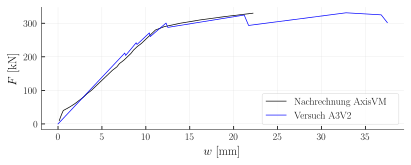

In [37]:
# Versuch Jaeger
w_1_versuch_A3V2 = np.array(
    [2.6, 10.2, 10.3, 11.5, 11.6, 13, 13.1, 14.9, 15.1, 23.8, 24.3, 35.4, 39.4, 40.1]
)
F_A_versuch_A3V2 = np.array(
    [
        0,
        211.3,
        204.1,
        241.9,
        236.8,
        271.3,
        260.3,
        300.6,
        287.7,
        324.6,
        293.5,
        331.2,
        325.1,
        301.8,
    ]
)

w_calc_a3v2 = np.array(
    [
        0.144,
        0.28,
        0.43,
        0.6,
        1.3,
        1.9,
        2.4,
        2.9,
        3.3,
        3.8,
        4.2,
        4.6,
        5,
        5.4,
        5.8,
        6.2,
        6.7,
        7,
        7.5,
        7.9,
        8.3,
        8.6,
        9,
        9.5,
        9.9,
        10.3,
        10.7,
        11.1,
        12.1,
        13.9,
        16.2,
        19,
        22.2,
    ]
)


F_calc_a3v2 = np.linspace(10, 330, 33)

plt.plot(w_calc_a3v2, F_calc_a3v2, color="black", label="Nachrechnung AxisVM")
plt.plot(
    w_1_versuch_A3V2 - w_1_versuch_A3V2[0],
    F_A_versuch_A3V2,
    color="blue",
    label="Versuch A3V2",
)
plt.xlabel("$w$ [mm]")
plt.ylabel("$F$ [kN]")
plt.legend()
plt.savefig("imgs/F_w_nachrechnung_A3V2.svg")
plt.show()

### Verdrehungsverlauf


In [38]:
DF_A3V2_LS320 = pd.read_excel("calcs\FEM\AxisVM\A3V2.xlsx")
x_array_A3V2 = np.linspace(0, 2620, len(DF_A3V2_LS320.iloc[:, 0]))

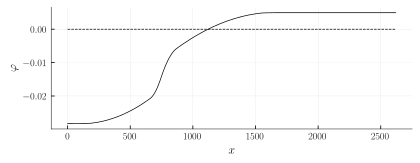

In [39]:
plt.plot(x_array_A3V2, DF_A3V2_LS320.iloc[:, -3], color="black")
plt.plot(x_array_A3V2, np.zeros(x_array_A3V2.shape), color="black", linestyle="dashed")

plt.xlabel("$x$")
plt.ylabel("$\\varphi$")
plt.show()

### Krümmungsverlauf

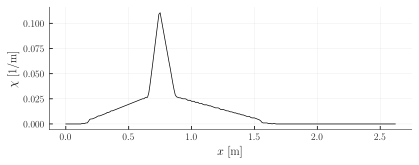

In [40]:
chi_a3v2 = np.gradient(DF_A3V2_LS320.iloc[:, -3], 0.01)

plt.plot(x_array_A3V2 / 1000, chi_a3v2, color="black")
plt.ylabel("$\\chi$ [1/m]")
plt.xlabel("$x$ [m]")
plt.savefig("imgs/kruemmungsverlauf_A3V2_axis.svg")
plt.show()

## SV14

### Drehfedercharakteristik

In [41]:
# Read the text file using numpy
M_SV14_array = np.loadtxt("docs/M_SV14.txt")
chi_SV14_array = np.loadtxt("docs/chi_SV14.txt")

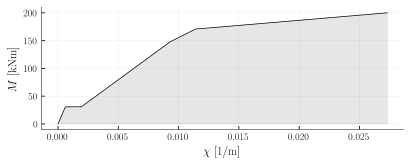

In [42]:
chi_SV14_interpolated = np.linspace(0, max(chi_SV14_array), 1000)
# Linear interpolation in M_array
M_SV14_interpolated = np.interp(chi_SV14_interpolated, chi_SV14_array, M_SV14_array)

# Plot the interpolated data
plt.plot(chi_SV14_interpolated, M_SV14_interpolated / 10**3, color="black")
plt.fill_between(
    chi_SV14_interpolated, M_SV14_interpolated / 10**3, color="black", alpha=0.1
)
plt.xlabel("$\chi$ [1/m]")
plt.ylabel("$M$ [kNm]")
plt.show()

In [43]:
M_SV14_array / 10**3

array([  0.        ,  30.74820557,  30.74820557, 147.42248657,
       170.8552959 , 200.13946777])

### Wegfedercharakteristik

#### Schiebung

Es wird das nicht-lineare Spannungs-Dehnungs-Verhalten der Schubbewehrung berücksichtigt. Zur Umwandlung in ein Kraft-Verformungs-Diagramm bzw. in eine Wegfedercharakteristik wird ein Spannungsfeld ermittelt. Aus diesem lässt sich die Querschnittsfläche der Schubbewehrung bestimmen. Durch Multiplikation mit der Spannung der Stahlkennlinie resultiert die erforderliche Kraft. Die bekannte Dehnung aus der Stahlkennlinie wird über den Hebelarm der inneren Kräfte zu einer Verformung umgewandelt. Wichtig dabei ist die Elementlänge der biegesteifen Stäbe im FEM-Modell. Dazu wird die Verformung um den Faktor gemäss @eq-red_element reduziert, bzw. die Steifigkeit der Feder um diesen Faktor erhöht.

$$
\gamma_{element} = \frac{z \cdot \cot(\theta)}{n_{Element}}
$${#eq-red_element}

In [44]:
sigma_w_SV14 = np.array([0.0, 550, 657]) * unit.N / unit.mm**2

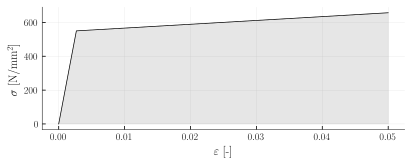

In [45]:
epsilon_w_SV14 = np.array([0.0, 550 / 205000, 0.05])

plt.plot(to_float(epsilon_w_SV14), to_float(sigma_w_SV14) / 1000**2, color="black")
plt.fill_between(
    to_float(epsilon_w_SV14), to_float(sigma_w_SV14) / 1000**2, color="black", alpha=0.1
)
plt.xlabel("$\\varepsilon$ [-]")
plt.ylabel("$\\sigma$ [N/mm$^2$]")
plt.show()

In [46]:
diam_sw = 4.3 * unit.mm
A_sw = 2 * (diam_sw / 2) ** 2 * np.pi
S_sw = 300 * unit.mm
a_sw = A_sw * 1000 * unit.mm / S_sw / unit.m
b_w = 170 * unit.mm
rho_sw = a_sw / b_w
z_approx = 359 * unit.mm
E_sw = 205000 * unit.N / unit.mm**2
E_sh = (sigma_w_SV14[-1] - sigma_w_SV14[-2]) / (epsilon_w_SV14[-1] - epsilon_w_SV14[-2])
theta_sw = 12.3 * unit.degree
display_eq(
    "\oslash_sw",
    diam_sw.evalf(3),
    "A_sw",
    A_sw.evalf(3),
    "S_sw",
    S_sw.evalf(3),
    "a_sw",
    a_sw.evalf(3),
    "b_w",
    b_w.evalf(3),
    "rho_sw",
    to_convert(rho_sw.evalf(3).simplify(), unit.percent),
    "z_approx",
    z_approx,
    "E_sw",
    E_sw,
    "E_sh",
    E_sh.evalf(4),
    "theta_c3",
    theta_sw,
)

\oslash_sw = 4.3⋅millimeter

                      2
A_sw = 29.0⋅millimeter 

S_sw = 300.0⋅millimeter

                      2
       96.8⋅millimeter 
a_sw = ────────────────
            meter      

b_w = 170.0⋅millimeter

ρ_sw = 0.0569⋅percent

zₐₚₚᵣₒₓ = 359⋅millimeter

       205000⋅newton
E_sw = ─────────────
                  2 
        millimeter  

      2261.0⋅newton
Eₛₕ = ─────────────
                 2 
       millimeter  

θ_c3 = 12.3°

##### Bewehrungseigenschaften

In [47]:
F_w_SV14 = sigma_w_SV14 * a_sw * z_approx * sp.cot(theta_sw)

E_s_SV14 = sigma_w_SV14 / epsilon_w_SV14

In [48]:
to_float(F_w_SV14)

array([     0.       ,  87673.0143516, 104729.40078  ])

In [53]:
gamma_element = z_approx * sp.cot(theta_sw) / l_element
u_sw_SV14 = epsilon_w_SV14 * z_approx / gamma_element

display_eq('\gamma_{Element}', np.round(to_float(gamma_element)))




\gamma_{Element} = 165.0

array([0.        , 0.00584973, 0.10901763])

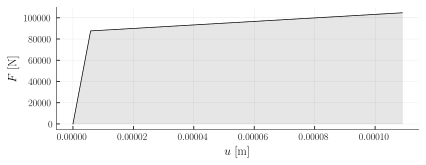

In [50]:
plt.plot(to_float(u_sw_SV14), to_float(F_w_SV14), color="black")
plt.fill_between(to_float(u_sw_SV14), to_float(F_w_SV14), color="black", alpha=0.1)
plt.xlabel("$u$ [m]")
plt.ylabel("$F$ [N]")
plt.show()

In [54]:
to_float(u_sw_SV14)*1000

array([0.        , 0.00584973, 0.10901763])